In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

import tensorflow as tf

from time import time

pd.set_option('display.precision', 3)

prng = np.random.RandomState(20250317)

# Clustering on image data

## Load the data

In [2]:

# Load MNIST dataset from Keras
from tensorflow.keras.datasets import mnist

# Load data with predefined train/test split
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Look at the dimensions
print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"X_test_full:  {X_test_full.shape}")
print(f"y_test_full:  {y_test_full.shape}")

X_train_full: (60000, 28, 28)
y_train_full: (60000,)
X_test_full:  (10000, 28, 28)
y_test_full:  (10000,)


In [4]:
# Note that we work here with numpy arrays instead of pandas dataframes
type(X_train_full)

numpy.ndarray

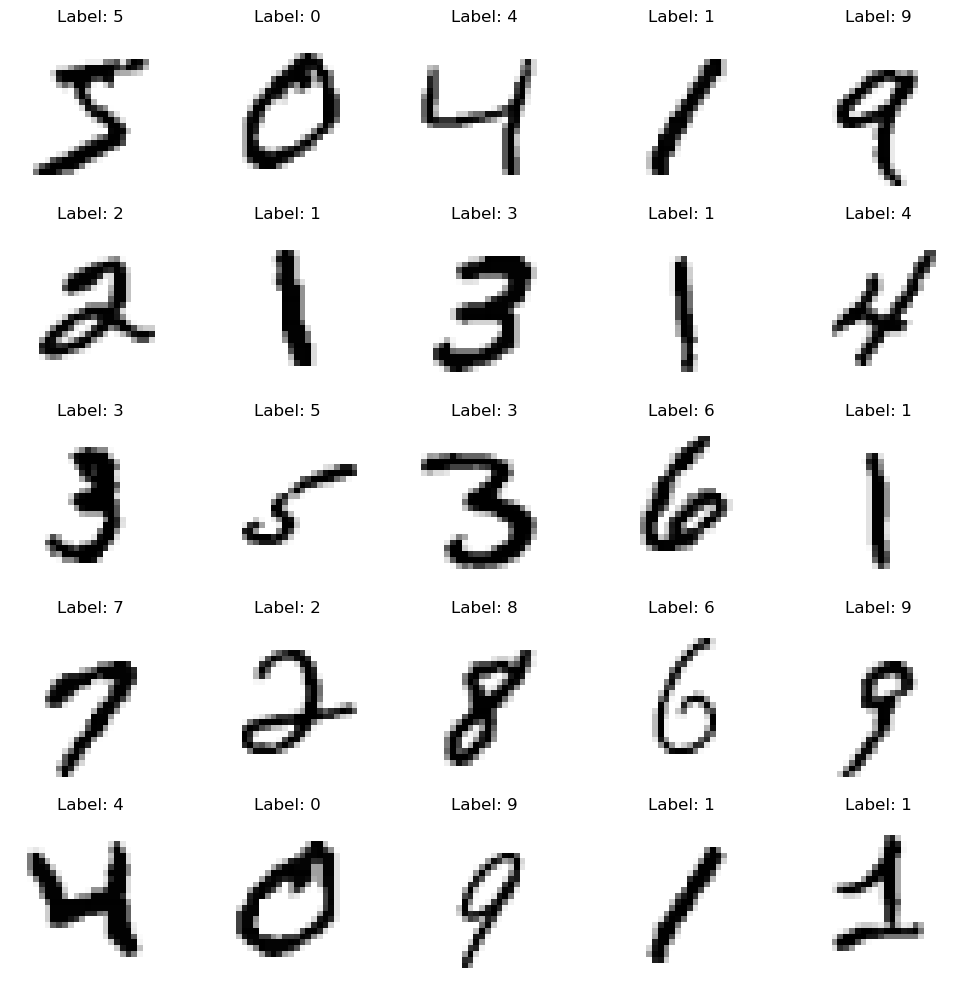

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train_full[i], cmap="binary")
    ax.axis("off")
    ax.set_title(f"Label: {y_train_full[i]}")
plt.tight_layout()
plt.show()

Note that our train data is multidimensional, instead of having `k` features, we have `i x j` features. In order to apply a standard ML algorithm, we need to flatten our data first to turn the 28x28 pixel images into 784 features. 

Since we need to apply the flattening to all datasets, a clever way to do this is to build this step into the pipeline. Since we are applying the transformation to the whole feature matrix rather than specific columns, we can use the `FunctionTransformer`, which can apply any user-defined function to the feature matrix. We can include the rescaling step as well.

## K-Means Clustering

In [4]:
def preprocessImageData(X):
    return X.reshape(X.shape[0], -1) / 255

### Full dataset

**TODO**: Calculate the K-Means cluster on the full dataset while also timing the process

In [5]:
pipe_kmeans_full = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("kmeans", KMeans(n_clusters=10, random_state=prng))
])

t0 = time()
pipe_kmeans_full.fit(X_train_full)
print(f"K-Means clustering completed in {time() - t0:.2f} seconds")

K-Means clustering completed in 2.25 seconds


### PCA (95% of the variance)

**TODO**: Calculate the K-Means cluster on a transformed dataset using PCA keeping 95% of the variance (while also timing the process)

In [7]:
pipe_kmeans_95 = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("pca", PCA(n_components=0.95)),
    ("kmeans", KMeans(n_clusters=10, random_state=prng))
])

t0 = time()
pipe_kmeans_95.fit(X_train_full)
print(f"K-Means clustering after PCA completed in {time() - t0:.2f} seconds")

K-Means clustering after PCA completed in 0.85 seconds


In [8]:
number_of_components_95 = pipe_kmeans_95['pca'].n_components_
print(f"{number_of_components_95} components explain at least 95% of the variance.")

154 components explain at least 95% of the variance.


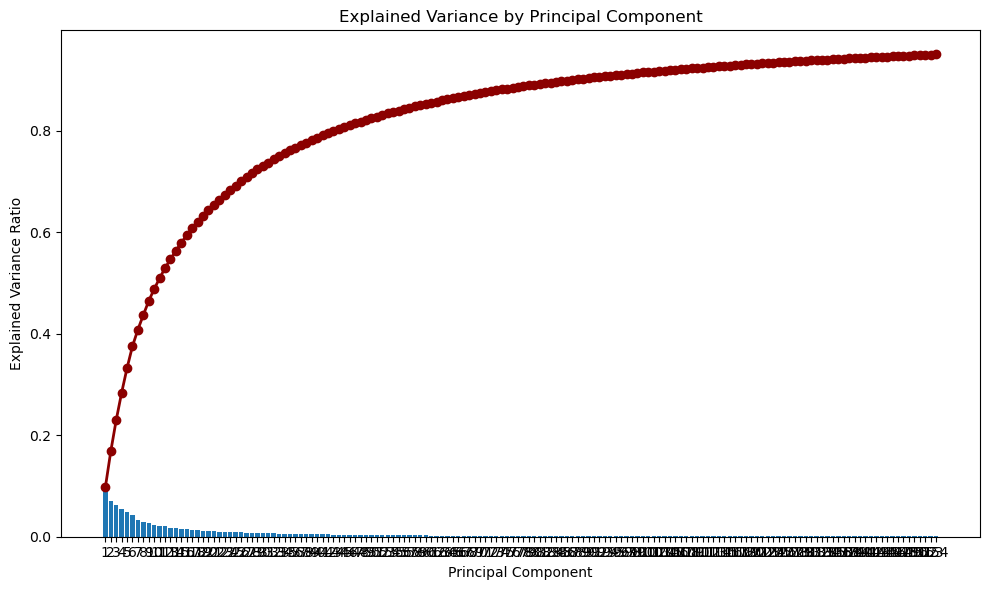

In [8]:
def visualizeExplainedVariance(explained_variance):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), color="darkred", marker="o", linewidth=2)

    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance by Principal Component")
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.tight_layout()

visualizeExplainedVariance(pipe_kmeans_95['pca'].explained_variance_ratio_)

In [9]:
print(f" The first 20 principal components capture {np.sum(pipe_kmeans_95['pca'].explained_variance_ratio_[:20]):.2%}% of the total variance")

 The first 20 principal components capture 64.36%% of the total variance


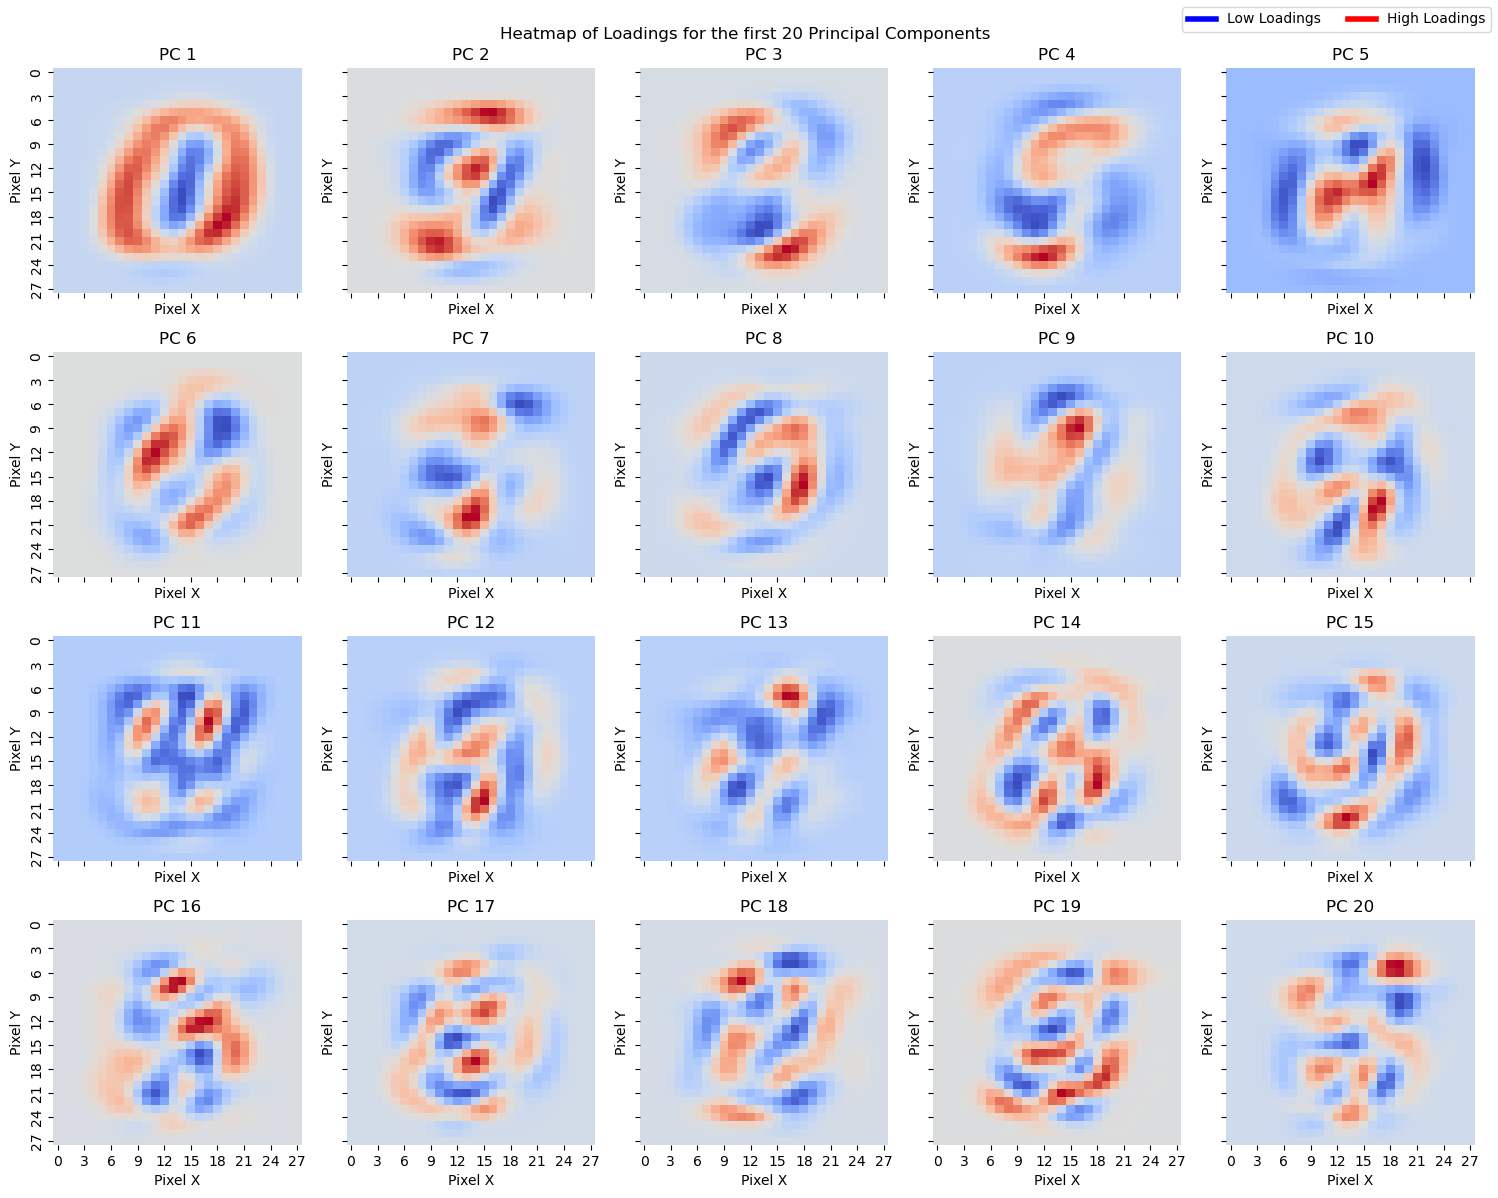

In [10]:
# Plot the loadings for the first 20 principal components
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex=True, sharey=True)
fig.suptitle("Heatmap of Loadings for the first 20 Principal Components")
axs = axs.flatten()

for i in range(20):
    pc_loadings = pipe_kmeans_95['pca'].components_[i].reshape(28, 28)

    # Plot the heatmap
    sns.heatmap(pc_loadings, cmap='coolwarm', annot=False, cbar=False, ax=axs[i])
    axs[i].set_title(f'PC {i+1}')
    axs[i].set_xlabel('Pixel X')
    axs[i].set_ylabel('Pixel Y')

handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Low Loadings'),
           plt.Line2D([0], [0], color='red', lw=4, label='High Loadings')]
fig.legend(handles=handles, loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

Shape of the transformed data:  (60000, 154)
Shape of the reconstructed data:  (60000, 784)


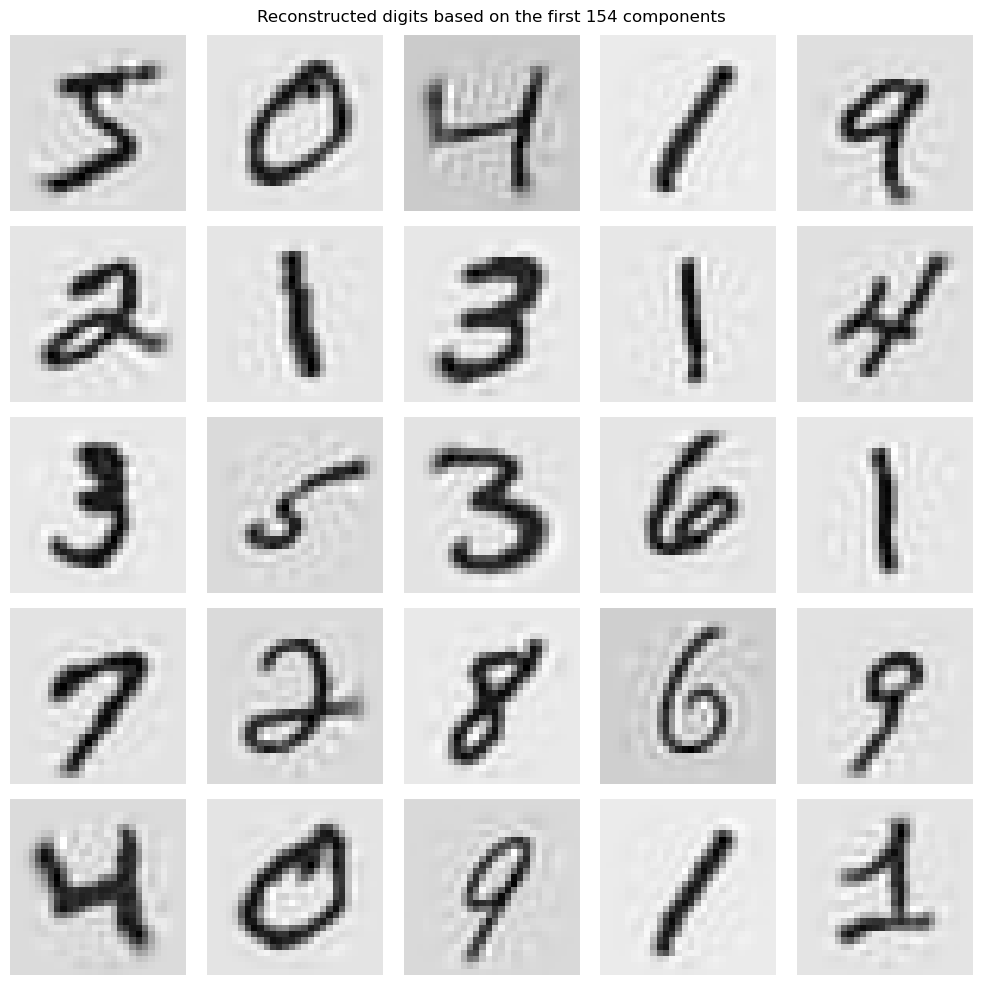

In [11]:
X_transformed = pipe_kmeans_95[:-1].transform(X_train_full)
print("Shape of the transformed data: ", X_transformed.shape)
X_train_reconstructed = pipe_kmeans_95['pca'].inverse_transform(X_transformed) # scaled version
print("Shape of the reconstructed data: ", X_train_reconstructed.shape)

fig, axs = plt.subplots(5, 5, figsize=(10,10))
fig.suptitle(f"Reconstructed digits based on the first {number_of_components_95} components")
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train_reconstructed[i].reshape(28, 28), cmap="binary")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Could we guess the number of clusters?

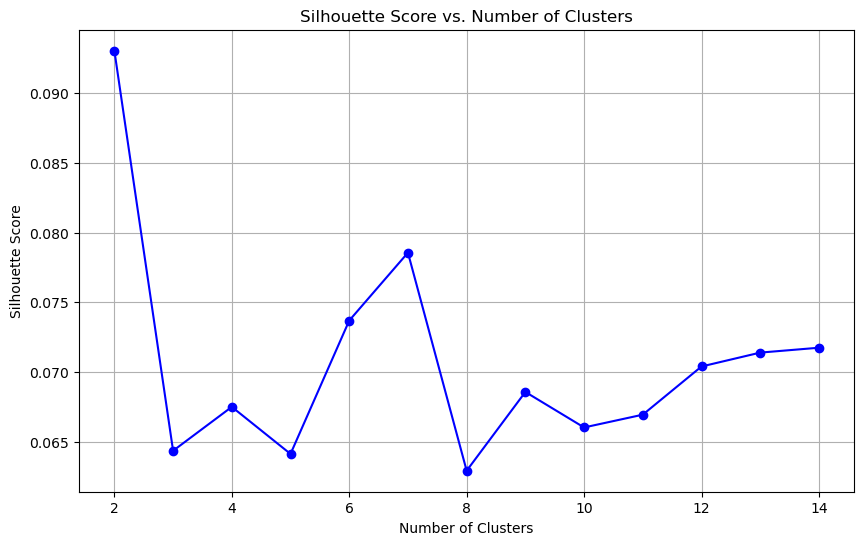

In [ ]:
X_pca = pipe_kmeans_95[:-1].transform(X_test_full) # transform validation data

cluster_range = range(2, 15)
silhouette_scores = []

for n in cluster_range:
    labels = KMeans(n_clusters=n).fit_predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'o-', color='darkblue')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.show()

### Evaluate the performance

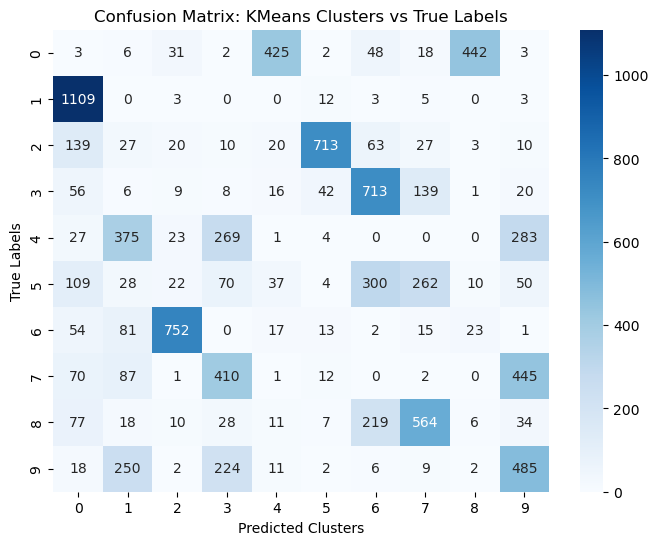

In [12]:

def plotConfusionMatrix(true_y, kmeans_labels):
    conf_matrix = confusion_matrix(true_y, kmeans_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: KMeans Clusters vs True Labels")
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")

test_clusters = pipe_kmeans_full.predict(X_test_full)
plotConfusionMatrix(y_test_full, test_clusters)

Can we calculate accuracy? Our previous method of choosing the most frequent true label would not work as multiple clusters would predict the same digit (e.g. both cluster 4 and 7 belong to digit 0).

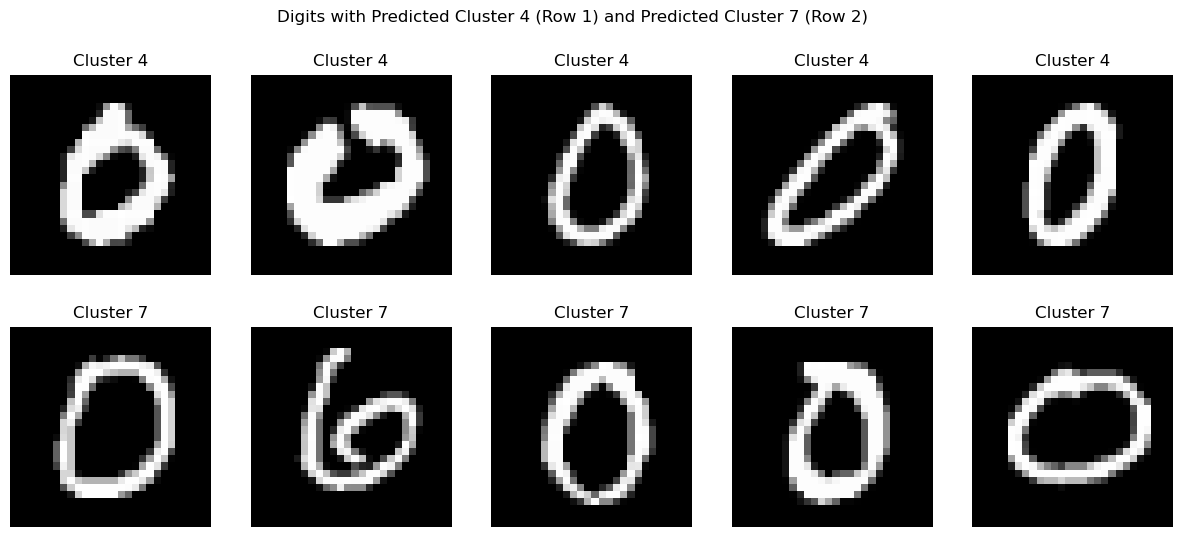

In [28]:
# Compare clusters that belong to the same digit

cluster_4_indices = np.where(test_clusters == 4)[0][:5]
cluster_7_indices = np.where(test_clusters == 7)[0][:5]

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(cluster_4_indices):
    axes[0, i].imshow(X_test_full[idx].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Cluster 4")

for i, idx in enumerate(cluster_7_indices):
    axes[1, i].imshow(X_test_full[idx].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Cluster 7")

plt.suptitle("Digits with Predicted Cluster 4 (Row 1) and Predicted Cluster 7 (Row 2)")
plt.show()


## Logistic regression

In [57]:
pipe_lr_full = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("lr", LogisticRegression(max_iter=1000, random_state=prng))
])

time0 = time()
pipe_lr_full.fit(X_train_full, y_train_full)
time_full = time() - time0
print(f"Logistic regression on full data completed in {time_full:.2f} seconds")

pipe_lr_pca = Pipeline([
    ("preprocess", FunctionTransformer(preprocessImageData)),
    ("pca", PCA(n_components=0.95)),
    ("lr", LogisticRegression(max_iter=1000, random_state=prng))
])

time0 = time()
pipe_lr_pca.fit(X_train_full, y_train_full)
time_pca = time() - time0
print(f"Logistic regression on PCA data completed in {time_pca:.2f} seconds")

Logistic regression on full data completed in 18.23 seconds
Logistic regression on PCA data completed in 2.80 seconds


In [58]:
# Compare performance metrics
# Summarize performance metrics in a transformed DataFrame
performance_summary_data = {
    'Metric': ['Dimensions', 'Fit time', 'Accuracy (training)', 'Accuracy (validation)'],
    'Full data': [X_train_reconstructed.shape[1], time_full, pipe_lr_full.score(X_train_full, y_train_full), pipe_lr_full.score(X_test_full, y_test_full)],
    'PCA': [number_of_components_95, time_pca, pipe_lr_pca.score(X_train_full, y_train_full), pipe_lr_pca.score(X_test_full, y_test_full)],
}
performance_summary_df = pd.DataFrame(performance_summary_data)
print(performance_summary_df)

                  Metric  Full data      PCA
0             Dimensions    784.000  154.000
1               Fit time     18.232    2.805
2    Accuracy (training)      0.939    0.927
3  Accuracy (validation)      0.926    0.923


In [59]:
# Try different numbers of PCA components to see impact on accuracy
print("\nEvaluating logistic regression with different numbers of PCA components...")
pca_components = [5, 10, 20, 30, 50, 75, 100, 150, 200, 400, 784]
accuracies = []
val_accuracies = []
times = []

# Decrease the data to quicken up computation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=10000, random_state=prng, stratify=y_train_full)

# Scale separately (so that it should not run again and again)
X_scaled = pipe_lr_pca['preprocess'].transform(X_train)
X_scaled_val = pipe_lr_pca['preprocess'].transform(X_val)

for n_components in pca_components:

    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('lr', LogisticRegression(max_iter=1000, random_state=prng))
    ])

    # Fit the model
    t0 = time()
    pipe.fit(X_scaled, y_train)
    time_fit = time() - t0
    
    # Calculate accuracy
    acc = accuracy_score(y_train, pipe.predict(X_scaled))
    validation_acc = accuracy_score(y_val, pipe.predict(X_scaled_val))
    
    # Store results
    times.append(time_fit)
    accuracies.append(acc)
    val_accuracies.append(validation_acc)


Evaluating logistic regression with different numbers of PCA components...


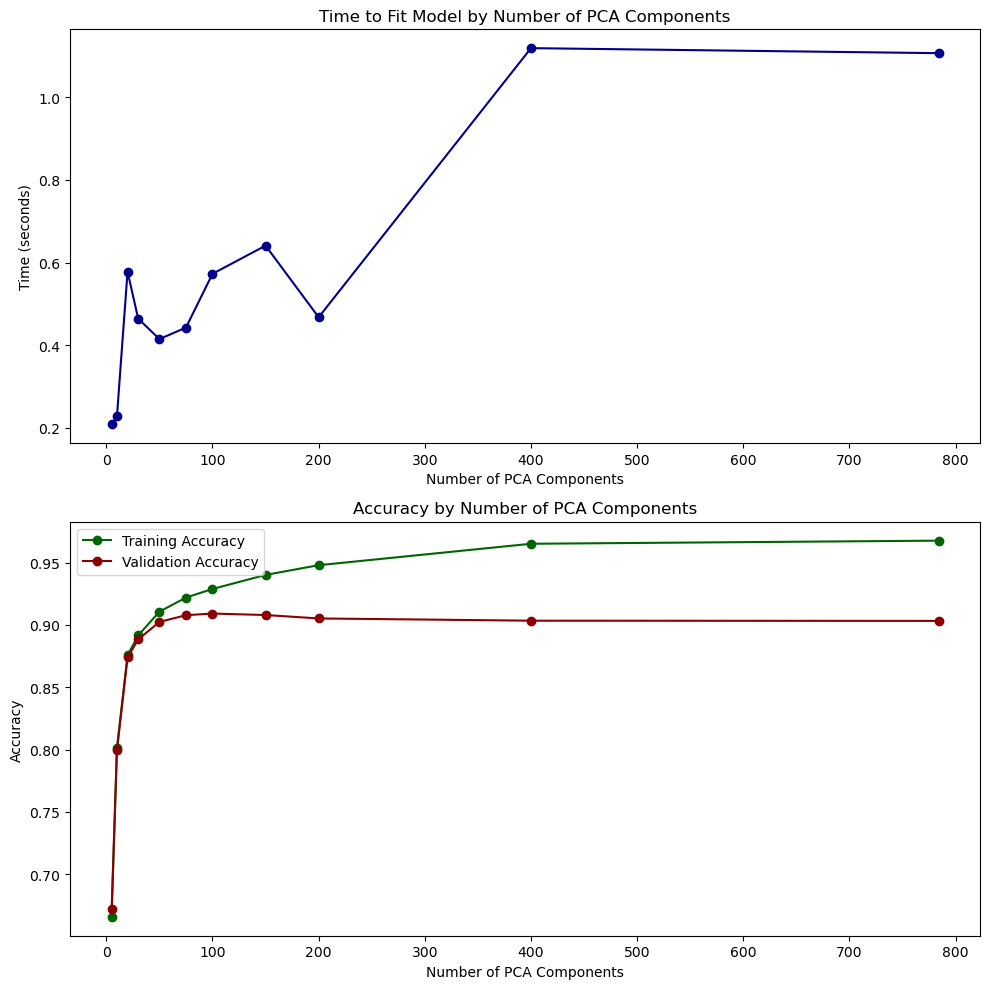

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# First plot: times by PCA components
ax[0].plot(pca_components, times, marker='o', color='darkblue')
ax[0].set_title('Time to Fit Model by Number of PCA Components')
ax[0].set_xlabel('Number of PCA Components')
ax[0].set_ylabel('Time (seconds)')

# Second plot: accuracies and val_accuracies by PCA components
ax[1].plot(pca_components, accuracies, marker='o', color='darkgreen', label='Training Accuracy')
ax[1].plot(pca_components, val_accuracies, marker='o', color='darkred', label='Validation Accuracy')
ax[1].set_title('Accuracy by Number of PCA Components')
ax[1].set_xlabel('Number of PCA Components')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()
